In [187]:
import parmed as pmd
import numpy as np
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [188]:
from adjustText import adjust_text
import plotting

In [317]:
smirnoff = pmd.load_file("systems/a-bam-p/smirnoff/a000/hg.prmtop")
smirnoff = smirnoff[":MGO"]

In [318]:
bgbg_tip3p = pmd.load_file("systems/a-bam-p/bgbg-tip3p/hg.topo")
bgbg_tip3p = bgbg_tip3p[":MGO"]

In [191]:
bg2bg2_tip3p = pmd.load_file("systems/a-bam-p/bg2bg2-tip3p/vac.topo")
bg2bg2_tip3p = bg2bg2_tip3p[":MGO"]

In [192]:
def scatter_lj(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []

    for index, row in df.iterrows():
        if row[x] != row[y]:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row[x], row[y], f"{row['name']}", color="r", size=14))


        else:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="0.5",
            )
    
    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(2, 2), arrowprops=dict(arrowstyle="-", color="r"))

    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [235]:
def scatter_bond(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []

    for index, row in df.iterrows():
        if row[x] != row[y]:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row[x], row[y], f"{row['atom1']}-{row['atom2']}", 
                                 color="r", size=14))


        else:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="0.5",
            )
    
    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(2, 2), arrowprops=dict(arrowstyle="-", color="k"))

    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [251]:
def scatter_angle(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []

    for index, row in df.iterrows():
        
        if row[x] != row[y]:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row[x], row[y], f"{row['atom1']}-{row['atom2']}-{row['atom3']}", color="r", size=14))

        else:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="0.5",
            )
    
    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(1, 1), 
                    expand_text=(2,2),
                    arrowprops=dict(arrowstyle="-", color="k"))

    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [272]:
def scatter_dihedral(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []

    for index, row in df.iterrows():
        
        if row[x] < -998:
#             ax.scatter(
#                 0,
#                 row[y],
#                 s=80,
#                 edgecolor="k",
#                 lw=0.4,
#                 color="w",
#             )
#             text.append(plt.text(0, row[y], f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}", color="0.5", size=14))
            continue
        elif row[y] < -998:
#             ax.scatter(
#                 row[x],
#                 0,
#                 s=80,
#                 edgecolor="k",
#                 lw=0.4,
#                 color="w",
#             )
#             text.append(plt.text(row[x], 0, f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}", color="0.5", size=14))
            continue
        
        elif row[x] != row[y]:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="none",
                lw=0.2,
                color="r",
                zorder=2,
            )
            text.append(plt.text(row[x], row[y], f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}", color="r", size=14))

        else:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="0.5",
            )
    
    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(1, 1), 
                    expand_text=(2,2), arrowprops=dict(arrowstyle="-", color="k"))

    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [196]:
smirnoff_lj = pd.DataFrame()

for atom in smirnoff.atoms:

    smirnoff_lj = smirnoff_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )


bgbg_tip3p_lj = pd.DataFrame()
for atom in bgbg_tip3p.atoms:

    bgbg_tip3p_lj = bgbg_tip3p_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )


In [197]:
df = smirnoff_lj.merge(bgbg_tip3p_lj, on="name", suffixes=("_smirnoff", "_bgbg_tip3p"),
                      how="outer")

In [198]:
df.head()

,name,type_smirnoff,epsilon_smirnoff,sigma_smirnoff,type_bgbg_tip3p,epsilon_bgbg_tip3p,sigma_bgbg_tip3p
0,C1,1,0.1094,3.39967,c3,0.1094,3.39967
1,C1,1,0.1094,3.39967,c3,0.1094,3.39967
2,C1,1,0.1094,3.39967,c3,0.1094,3.39967
3,C1,1,0.1094,3.39967,c3,0.1094,3.39967
4,C1,1,0.1094,3.39967,c3,0.1094,3.39967


In [199]:
df.drop_duplicates(inplace=True, subset=["epsilon_smirnoff", "sigma_smirnoff", "epsilon_bgbg_tip3p", "sigma_bgbg_tip3p"])

In [200]:
df.head()

,name,type_smirnoff,epsilon_smirnoff,sigma_smirnoff,type_bgbg_tip3p,epsilon_bgbg_tip3p,sigma_bgbg_tip3p
0,C1,1,0.1094,3.399670,c3,0.1094,3.399670
36,H1,2,0.0157,2.293173,h2,0.0157,2.293173
72,O1,3,0.1700,3.000012,os,0.1700,3.000012
144,H2,5,0.0157,2.471353,h1,0.0157,2.471353
180,O2,6,0.2104,3.066473,oh,0.2104,3.066473


In [201]:
df.to_csv("results/lennard-jones.csv")

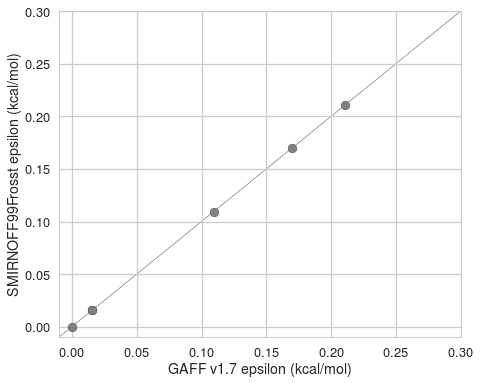

In [219]:
scatter_lj(df, "epsilon_bgbg_tip3p", "epsilon_smirnoff", "GAFF v1.7 epsilon (kcal/mol)", "SMIRNOFF99Frosst epsilon (kcal/mol)", 
        -0.01, 0.3, "r", "SMIRNOFF99Frosst-vs-GAFF-v1.7-epsilon.pdf", adjust=True)

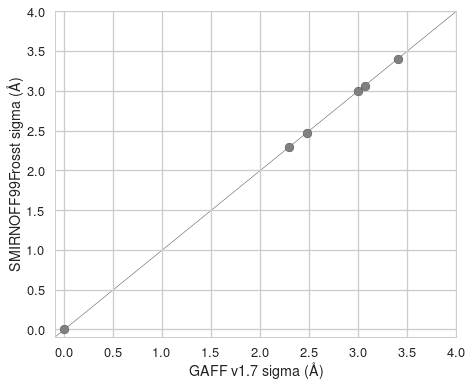

In [218]:
scatter_lj(df, "sigma_bgbg_tip3p", "sigma_smirnoff", "GAFF v1.7 sigma (\AA)", "SMIRNOFF99Frosst sigma (\AA)", -0.1, 4, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-sigma.pdf")


# Bonds

In [220]:
def find_bonds(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for bond in atom.bonds:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": bond.atom1.name,
                        "atom2": bond.atom2.name,
                        "atom1_type": bond.atom1.type,
                        "atom2_type": bond.atom2.type,
                        "req": bond.type.req,
                        "k": bond.type.k,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [221]:
smirnoff_bonds = find_bonds(smirnoff)
bgbg_tip3p_bonds = find_bonds(bgbg_tip3p)

In [222]:
df = smirnoff_bonds.merge(bgbg_tip3p_bonds, on=["atom1", "atom2"], suffixes=("_smirnoff", "_bgbg_tip3p"),
                         how="outer")

In [223]:
df.head()

,atom1,atom2,atom1_type_smirnoff,atom2_type_smirnoff,req_smirnoff,k_smirnoff,atom1_type_bgbg_tip3p,atom2_type_bgbg_tip3p,req_bgbg_tip3p,k_bgbg_tip3p
0,C1,O1,1,3,1.37,320.0,c3,os,1.439,301.5
1,C1,O1,1,3,1.37,320.0,c3,os,1.439,301.5
2,C1,O1,1,3,1.37,320.0,c3,os,1.439,301.5
3,C1,O1,1,3,1.37,320.0,c3,os,1.439,301.5
4,C1,O1,1,3,1.37,320.0,c3,os,1.439,301.5


In [224]:
df.drop_duplicates(inplace=True, subset=["k_smirnoff", "req_smirnoff", "k_bgbg_tip3p", "req_bgbg_tip3p"])

In [225]:
df.to_csv("results/bonds.csv")

In [226]:
df[["k_smirnoff", "k_bgbg_tip3p"]].min()
df[["k_smirnoff", "k_bgbg_tip3p"]].max()

k_smirnoff      553.0
k_bgbg_tip3p    369.6
dtype: float64

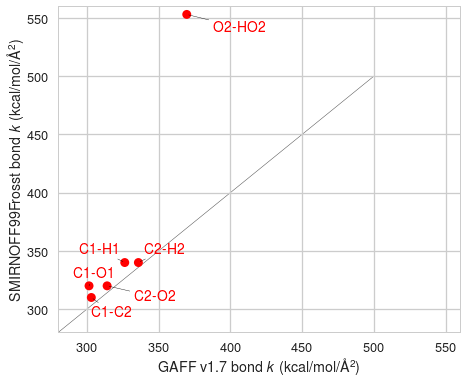

In [238]:
scatter_bond(df, "k_bgbg_tip3p", "k_smirnoff", r"GAFF v1.7 bond $k$ (kcal/mol/\AA$^2$)", 
             r"SMIRNOFF99Frosst bond $k$ (kcal/mol/\AA$^2$)", 280, 560, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-k.pdf", adjust=True)


In [19]:
df[["req_smirnoff", "req_bgbg_tip3p"]].min()

req_smirnoff      0.960
req_bgbg_tip3p    0.974
dtype: float64

In [20]:
df[["req_smirnoff", "req_bgbg_tip3p"]].max()

req_smirnoff      1.526
req_bgbg_tip3p    1.535
dtype: float64

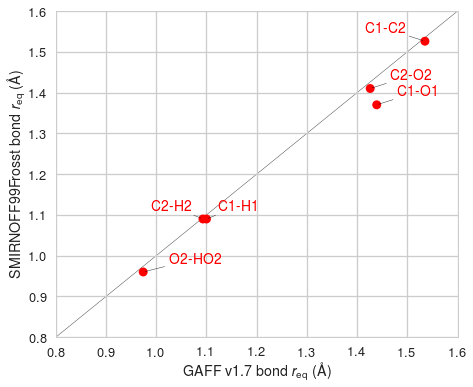

In [239]:
scatter_bond(df, "req_bgbg_tip3p", "req_smirnoff", r"GAFF v1.7 bond $r_\text{eq}$ (\AA)", 
             r"SMIRNOFF99Frosst bond $r_\text{eq}$ (\AA)", 0.8, 1.6, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-req.pdf", adjust=True)


# Angles

In [240]:
def find_angles(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for angle in atom.angles:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": angle.atom1.name,
                        "atom2": angle.atom2.name,
                        "atom3": angle.atom3.name,
                        "k": angle.type.k,
                        "theta_eq": angle.type.theteq,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df

In [241]:
smirnoff_angles = find_angles(smirnoff)
bgbg_tip3p_angles = find_angles(bgbg_tip3p)
bg2bg2_tip3p_angles = find_angles(bg2bg2_tip3p)

In [242]:
df = smirnoff_angles.merge(bgbg_tip3p_angles, on=["atom1", "atom2", "atom3"], 
                              suffixes=("_smirnoff", "_bgbg_tip3p"),
                             how="outer")

In [243]:
df.head()

,atom1,atom2,atom3,k_smirnoff,theta_eq_smirnoff,k_bgbg_tip3p,theta_eq_bgbg_tip3p
0,O1,C1,C2,50.0,109.5,67.78,108.420047
1,O1,C1,C2,50.0,109.5,67.78,108.420047
2,O1,C1,C2,50.0,109.5,67.78,108.420047
3,O1,C1,C2,50.0,109.5,67.78,108.420047
4,O1,C1,C2,50.0,109.5,67.78,108.420047


In [244]:
df.drop_duplicates(inplace=True, subset=["k_smirnoff", 
                                         "theta_eq_smirnoff",
                                         "k_bgbg_tip3p",
                                         "theta_eq_bgbg_tip3p"])

In [245]:
df.to_csv("results/angles.csv")

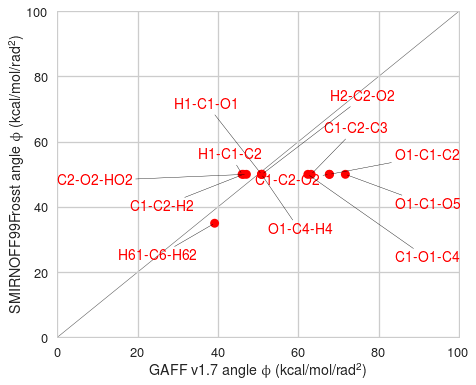

In [252]:
scatter_angle(df, "k_bgbg_tip3p", "k_smirnoff", r"GAFF v1.7 angle $\phi$ (kcal/mol/rad$^2$)", r"SMIRNOFF99Frosst angle $\phi$ (kcal/mol/rad$^2$)", 
        0, 100, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-ang-k.pdf",
       adjust=True)


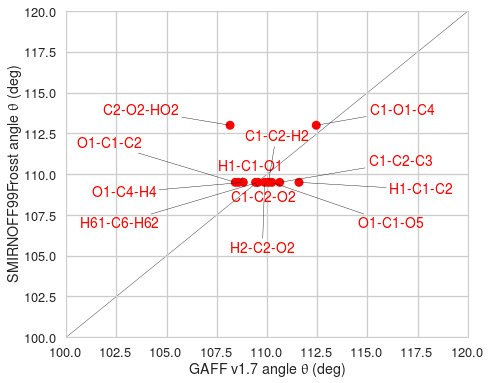

In [253]:
scatter_angle(df, "theta_eq_bgbg_tip3p", "theta_eq_smirnoff", r"GAFF v1.7 angle $\theta$ (deg)", r"SMIRNOFF99Frosst angle $\theta$ (deg)", 
        100, 120, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-ang-theta.pdf",
       adjust=True)


# Dihedrals

In [274]:
def find_dihedrals(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for dihedral in atom.dihedrals:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": dihedral.atom1.name,
                        "atom2": dihedral.atom2.name,
                        "atom3": dihedral.atom3.name,
                        "atom4": dihedral.atom4.name,
                        "phi_k": dihedral.type.phi_k,
                        "per": dihedral.type.per,
                        "phase": dihedral.type.phase,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [275]:
smirnoff_dihedrals = find_dihedrals(smirnoff)
bgbg_tip3p_dihedrals = find_dihedrals(bgbg_tip3p)
bg2bg2_tip3p_dihedrals = find_dihedrals(bg2bg2_tip3p)

In [276]:
df = smirnoff_dihedrals.merge(bgbg_tip3p_dihedrals, on=["atom1", "atom2", "atom3", "atom4", "per"], 
                              suffixes=("_smirnoff", "_bgbg_tip3p"),
                             how="outer")

The "outer" merge, should keep NA entries.

In [257]:
df.head()

,atom1,atom2,atom3,atom4,phi_k_smirnoff,per,phase_smirnoff,phi_k_bgbg_tip3p,phase_bgbg_tip3p
0,O1,C1,C2,O2,0.144,3,0.0,0.144,0.0
1,O1,C1,C2,O2,0.144,3,0.0,0.144,0.0
2,O1,C1,C2,O2,0.144,3,0.0,0.144,0.0
3,O1,C1,C2,O2,0.144,3,0.0,0.144,0.0
4,O1,C1,C2,O2,0.144,3,0.0,0.144,0.0


In [258]:
df.drop_duplicates(inplace=True, subset=["phase_smirnoff", 
                                         "phi_k_smirnoff",
                                         "phase_bgbg_tip3p",
                                         "phi_k_bgbg_tip3p"])

In [259]:
df.head()

,atom1,atom2,atom3,atom4,phi_k_smirnoff,per,phase_smirnoff,phi_k_bgbg_tip3p,phase_bgbg_tip3p
0,O1,C1,C2,O2,0.144,3,0.0,0.144000,0.0
576,O1,C1,C2,O2,1.175,2,0.0,1.175000,0.0
1152,O1,C1,C2,C3,0.156,3,0.0,0.155556,0.0
1744,O5,C1,C2,O2,1.175,2,0.0,NaN,NaN
1748,O5,C1,C2,C3,0.156,3,0.0,NaN,NaN


In [260]:
df[["phi_k_smirnoff", "phi_k_bgbg_tip3p"]].max()

phi_k_smirnoff      1.35
phi_k_bgbg_tip3p    1.35
dtype: float64

In [261]:
df[["phi_k_smirnoff", "phi_k_bgbg_tip3p"]].min()

phi_k_smirnoff      0.0
phi_k_bgbg_tip3p    0.0
dtype: float64

In [262]:
df.to_csv("results/dihedrals.csv")

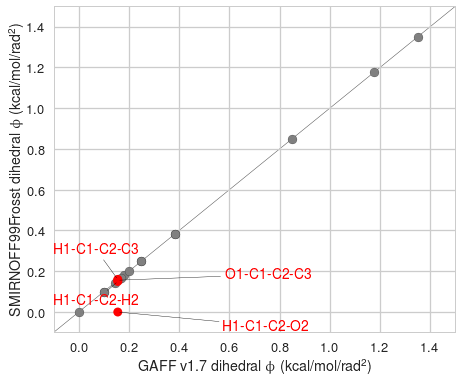

In [273]:
scatter_dihedral(df.dropna(), "phi_k_bgbg_tip3p", "phi_k_smirnoff", r"GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)", r"SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-dih-phi.pdf",
       adjust=True)


In [ ]:
df = bgbg_tip3p_dihedrals.merge(bg2bg2_tip3p_dihedrals, on=["atom1", "atom2", "atom3", "atom4", "per"], 
                              suffixes=("_bgbg_tip3p", "_bg2bg2_tip3p"))

df.drop_duplicates(inplace=True, subset=["phase_bgbg_tip3p", 
                                         "phi_k_bgbg_tip3p",
                                         "phase_bg2bg2_tip3p",
                                         "phi_k_bg2bg2_tip3p"])

print(f'Max: {df[["phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p"]].max()}')
print(f'Min: {df[["phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p"]].min()}')

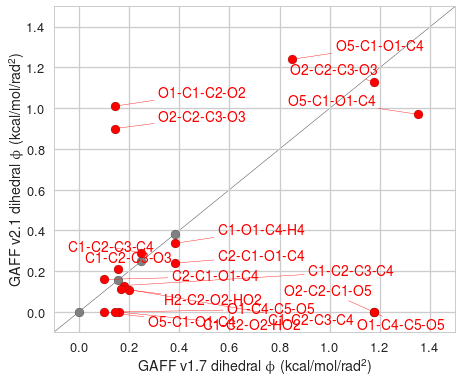

In [23]:
scatter(df, "phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p", r"GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)", r"GAFF v2.1 dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", 
        "GAFF-v2.1-vs-GAFF-v1.7-dih-phi.pdf",
       adjust=True)


In [ ]:
# Use ParmeEd to load in `prmtop` and write `frcmod`.
# Then, extract just the dihedral section...
# (Maybe I should also include the impropers...)
# sed -n '/DIH/,/IMP/p' hg.frcmod > hg.dih.csv
# http://ambermd.org/formats.html#frcmod

smirnoff = pd.read_csv("systems/a-bam-p/smirnoff/hg.dih.csv",
           header=1, skipfooter=1, sep="\s{2,}",
           names=["atoms", "?", "phi", "phase", "per", "scaling"])

1. Limit this to `:MGO`
2. Find a way to write this by atom name...? Perhaps not possible.
3. Loop through dihedrals in ParmEd, write them in a similar format to `frcmod` and see if I can spot the differences.

In [302]:
smirnoff.drop_duplicates(subset=["phi", "phase", "per"], inplace=True)

In [303]:
len(smirnoff)

18

In [298]:
bgbg_tip3p = pd.read_csv("systems/a-bam-p/bgbg-tip3p/hg.dih.csv",
           header=1, skipfooter=1, sep="\s{2,}",
           names=["atoms", "?", "phi", "phase", "per", "scaling"])

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


In [306]:
bgbg_tip3p.drop_duplicates(subset=["phi", "phase", "per"], inplace=True)

In [307]:
len(bgbg_tip3p)

17

In [314]:
smirnoff.sort_values(by="phi", ascending=False)

,atoms,?,phi,phase,per,scaling
191,16-1 -3 -33,1,1.350000,180.0,1.0,SCEE=1.0 SCNB=1.0
0,3 -1 -4 -6,1,1.175000,0.0,2.0,SCEE=1.0 SCNB=1.0
190,16-1 -3 -33,1,0.850000,180.0,-2.0,SCEE=1.0 SCNB=1.0
643,1 -3 -33-34,1,0.383333,0.0,3.0,SCEE=1.20000048 SCNB=2.0
183,1 -3 -33-35,1,0.383000,0.0,-3.0,SCEE=1.20000048 SCNB=2.0
10,1 -4 -8 -12,1,0.250000,180.0,-2.0,SCEE=1.0 SCNB=1.0
292,3 -1 -4 -5,1,0.250000,0.0,1.0,SCEE=1.0 SCNB=1.0
11,1 -4 -8 -12,1,0.200000,180.0,1.0,SCEE=1.0 SCNB=1.0
9,1 -4 -8 -12,1,0.180000,0.0,-3.0,SCEE=1.20000048 SCNB=2.0
563,5 -4 -6 -7,1,0.166667,0.0,3.0,SCEE=1.20000048 SCNB=2.0


In [315]:
bgbg_tip3p.sort_values(by="phi", ascending=False)

,atoms,?,phi,phase,per,scaling
0,os-c3-os-c3,1,1.350000,180.0,-1.0,SCEE=1.2 SCNB=2.0
3,os-c3-c3-os,1,1.175000,0.0,-2.0,SCEE=1.2 SCNB=2.0
1,os-c3-os-c3,1,0.850000,180.0,-2.0,SCEE=1.2 SCNB=2.0
25,h1-c3-os-c3,1,0.383333,0.0,3.0,SCEE=1.2 SCNB=2.0
8,c3-c3-os-c3,1,0.383000,0.0,3.0,SCEE=1.2 SCNB=2.0
17,os-c3-c3-h1,1,0.250000,0.0,-1.0,SCEE=1.2 SCNB=2.0
11,c3-c3-c3-c3,1,0.250000,180.0,-2.0,SCEE=1.2 SCNB=2.0
10,c3-c3-c3-c3,1,0.200000,180.0,-1.0,SCEE=1.2 SCNB=2.0
12,c3-c3-c3-c3,1,0.180000,0.0,3.0,SCEE=1.2 SCNB=2.0
16,h1-c3-oh-ho,1,0.166667,0.0,3.0,SCEE=1.2 SCNB=2.0


In [319]:
smirnoff_dihedrals = find_dihedrals(smirnoff)
bgbg_tip3p_dihedrals = find_dihedrals(bgbg_tip3p)

In [320]:
smirnoff_dihedrals

,atom1,atom2,atom3,atom4,phi_k,per,phase
0,O1,C1,C2,O2,0.144000,3,0.0
1,O1,C1,C2,O2,1.175000,2,0.0
2,O1,C1,C2,C3,0.156000,3,0.0
3,O5,C1,C2,O2,0.144000,3,0.0
4,O5,C1,C2,O2,1.175000,2,0.0
5,O5,C1,C2,C3,0.156000,3,0.0
6,C1,C2,C3,O3,0.156000,3,0.0
7,C1,C2,C3,C4,0.180000,3,0.0
8,C1,C2,C3,C4,0.250000,2,180.0
9,C1,C2,C3,C4,0.200000,1,180.0


In [321]:
bgbg_tip3p_dihedrals

,atom1,atom2,atom3,atom4,phi_k,per,phase
0,O5,C1,O1,C4,1.350000,1,180.000077
1,O5,C1,O1,C4,0.850000,2,180.000077
2,O5,C1,O1,C4,0.100000,3,0.000000
3,C3,C2,C1,O5,0.155556,3,0.000000
4,O2,C2,C1,O5,1.175000,2,0.000000
5,O5,C1,C2,O2,0.144000,3,0.000000
6,C2,C1,O1,C4,0.100000,2,180.000077
7,C2,C1,O1,C4,0.383000,3,0.000000
8,C2,C1,O5,C5,0.100000,2,180.000077
9,C2,C1,O5,C5,0.383000,3,0.000000


In [336]:
smirnoff_torsion_count = smirnoff_dihedrals.groupby(["atom1", "atom2", "atom3", "atom4"]).size().reset_index().rename(columns={0:'count'})


In [337]:
bgbg_torsion_count = bgbg_tip3p_dihedrals.groupby(["atom1", "atom2", "atom3", "atom4"]).size().reset_index().rename(columns={0:'count'})


In [356]:
smirnoff_torsion_count.head()
smirnoff_torsion_count["count"] = smirnoff_torsion_count["count"].astype(int)

In [361]:
bgbg_torsion_count.head()
bgbg_torsion_count["count"] = bgbg_torsion_count["count"].astype(int)

In [364]:
merged_torsions = pd.merge(smirnoff_torsion_count, bgbg_torsion_count, 
                           on=["atom1", "atom2", "atom3", "atom4"], 
                           how='outer', 
                           suffixes=('_smirnoff', '_bgbg_tip3p'),)

In [366]:
merged_torsions["difference"] = merged_torsions["count_smirnoff"] - merged_torsions["count_bgbg_tip3p"]

In [367]:
merged_torsions[merged_torsions["difference"] != 0]

,atom1,atom2,atom3,atom4,count_smirnoff,count_bgbg_tip3p,difference
16,C3,C2,C1,O5,20,24.0,-4.0
32,H1,C1,C2,O2,48,24.0,24.0
35,H2,C2,C1,O5,40,44.0,-4.0
66,O2,C2,C1,O5,40,44.0,-4.0
73,O5,C1,C2,C3,4,NaN,NaN
74,O5,C1,C2,H2,8,4.0,4.0
75,O5,C1,C2,O2,8,4.0,4.0


In [385]:
molecules = 1000
mu, sigma = 500, 50
volumes = np.random.normal(mu, sigma, 10000) # 10000 random volume samples, mean = 500, std dev = 50

In [386]:
# Method 1
mean_density = np.mean(molecules / volumes)
print(f"Method #1: {mean_density}")

Method #1: 2.0223587821226108


In [387]:
# Method 2
mean_density = molecules / np.mean(volumes)
print(f"Method #2: {mean_density}")

Method #2: 2.001992765403177
